# Generate Reference Profiles for Cell Subpopulations

This notebook uses a previously trained generative model and cluster assignments to generate reference profiles representative of each cluster. 

Specifically, each cell profile is encoded into its latent space representation, and a cluster-specific latent vector is derived by averaging the individual latent vectors of cells in that cluster. Then, the cluster-specific latent vectors are fed into the generator (or decoder) to produce a __reference__ profile.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import tensorflow as tf
from sklearn import preprocessing
from sklearn.manifold import TSNE

from framework.common.dataset import Dataset
from framework.keras.autoencoder import VariationalAutoencoder as VAE

np.random.seed(1013)
tf.set_random_seed(1013)

Using TensorFlow backend.


In [28]:
# Model directory
dataset = "GBM"
model_dir = "results/{}/Train1000g{}VAE/{}VAE_Final".format(
    dataset.lower(), dataset, dataset)

# File that lists the cluster associated with each cell
cluster_file = model_dir + "/consensus_clusters_k10.txt"
# Which column in the file to use as the clusters
cluster_col = "consensus_cluster"

dataset_file = "data/GSE57872_GBM/processed/gbm.1000g.centered.txt"
# GSE57872_GBM; GSE72056_Melanoma, GSE75688_Breast_Cancer
dataset_features_start_idx = 1
# Start indexes: melanoma = 1; gbm = 1; breast = 2

latent_space_file = model_dir + "/latent_representations.txt"
# What column in latent space file marks the end of 
# the features and the beginning of labels/other information
features_end_col_idx = -1

In [29]:
def load_dataset():
    dataset = pd.read_csv(dataset_file, sep="\t", header=0, index_col=0)
    features = dataset.iloc[:, dataset_features_start_idx:].values.astype(dtype=np.float64)
    cell_ids = dataset.index.values
    
    return dataset, cell_ids, features

def load_latent_space():
    df = pd.read_csv(latent_space_file, sep="\t", header=0, index_col=0)
    latent_space = df.iloc[:, 0:features_end_col_idx]
    
    return latent_space

def load_clusters():
    clusters_df = pd.read_csv(cluster_file, sep="\t", header=0, index_col=0)
    clusters = clusters_df.loc[:, cluster_col]
    return clusters

dataset, cell_ids, features = load_dataset()
latent_space = load_latent_space()

scaler = preprocessing.StandardScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)

clusters = load_clusters()
clusters = clusters[cell_ids]

latent_space = latent_space.loc[cell_ids, :].values.astype(dtype=np.float64)

classes = np.unique(clusters.values)
print("Number of Clusters:", len(classes))

vae = VAE.restore(model_dir)
# latent_space = vae.encode(features_scaled)
# test_dataset = Dataset(features_scaled, features_scaled, sample_data=[cell_ids])

Number of Clusters: 10


In [30]:
# Generate expression profiles (using the scaled distribution)
reference_profiles = OrderedDict()
cluster_vectors = OrderedDict()
for c in classes:
    # Get latent space vectors for each cell in the cluster
    latent_vectors = latent_space[clusters == c,]
    # Average the latent vectors to derive a consensus vector for that cluster
    cluster_vector = np.expand_dims(np.average(latent_vectors, axis=0), axis=0)
    cluster_vectors[c] = np.squeeze(cluster_vector)
    
    # Generate a reference profile from the cluster vector
    cluster_reference_profile = vae.generate(cluster_vector)
    cluster_reference_profile = scaler.inverse_transform(cluster_reference_profile)
    reference_profiles[c] = np.squeeze(cluster_reference_profile)
    
    print("Generated reference profile for cluster", c)

Generated reference profile for cluster 1
Generated reference profile for cluster 2
Generated reference profile for cluster 3
Generated reference profile for cluster 4
Generated reference profile for cluster 5
Generated reference profile for cluster 6
Generated reference profile for cluster 7
Generated reference profile for cluster 8
Generated reference profile for cluster 9
Generated reference profile for cluster 10


In [31]:
encoded_reference_profiles = vae.encode(
    scaler.transform(np.array(list(reference_profiles.values()))))

In [33]:
# Fit a t-SNE model to the features for visualization purposes
def fit_tsne(features):
    tsne_model = TSNE(n_components=2, init='pca', random_state=0, perplexity=30)
    return tsne_model.fit_transform(features)

tsne_output = fit_tsne(np.vstack(
    (latent_space, 
     np.array(list(cluster_vectors.values())),
     encoded_reference_profiles)
))

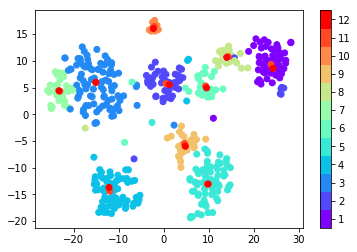

In [34]:
tsne_plot_labels = list(np.hstack(
    (clusters, 
     np.repeat(np.max(clusters) + 1, len(classes)),
     np.repeat(np.max(clusters) + 2, len(encoded_reference_profiles))
    )
))
plt.scatter(tsne_output[:, 0], tsne_output[:, 1], 
            c=tsne_plot_labels, cmap=plt.cm.get_cmap(
                "rainbow", len(np.unique(tsne_plot_labels))))
plt.colorbar(ticks=np.unique(tsne_plot_labels))
plt.clim(np.min(tsne_plot_labels)-0.5, np.max(tsne_plot_labels) + 0.5)
plt.show()

In [35]:
# Save cluster vectors
cluster_vectors_df = pd.DataFrame.from_dict(cluster_vectors, orient="index")
cluster_vectors_df.index.name = "cluster_id"
cluster_vectors_df.columns = ["dim" + str(i) for i in range(
    1, len(cluster_vectors[next(iter(cluster_vectors))]) + 1)]
cluster_vectors_df.to_csv(model_dir + "/cluster_vectors/cluster_vectors_k" + str(len(classes)) + ".txt", 
                          index=True, sep="\t")

# Save reference profiles
reference_profiles_df = pd.DataFrame.from_dict(reference_profiles, orient="index")
reference_profiles_df.index.name = "cluster_id"
reference_profiles_df.columns = dataset.columns[dataset_features_start_idx:]
reference_profiles_df.to_csv(model_dir + "/reference_profiles/reference_profiles_k" + str(len(classes)) + ".txt", 
                             index=True, sep="\t")